In [1]:
# !git clone https://github.com/hmanhduc2k/CS4243-Mini-Project # Uncomment this to clone it once
%cd CS4243-Mini-Project
!git pull
!git checkout wilfred/model
!ls

/content/CS4243-Mini-Project
Already up to date.
Already on 'wilfred/model'
Your branch is up to date with 'origin/wilfred/model'.
CS4243_MiniProject.ipynb  README.md	    template.py
data			  requirements.txt  WeaponDetection.pth


In [2]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/cs4243_smallest
!ls

In [2]:
import gc

import pandas as pd
from sklearn.metrics import classification_report

import torch
import torchvision
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

from PIL import Image

torch.manual_seed(42)

import torch.optim as optim
from torch.optim import Adam

from transformers import T5ForConditionalGeneration, AutoTokenizer, Adafactor

import matplotlib.pyplot as plt
import numpy as np

# **Do data visualization, data preparation here**

---



In [12]:
train_df = pd.read_csv("train_label.csv")
test_df = pd.read_csv("test_label.csv")
count = len(train_df)
normal_count = len(train_df[train_df["label"] == 0])
carrying_count = len(train_df[train_df["label"] == 1])
threat_count = len(train_df[train_df["label"] == 2])
print(f'TRAIN: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

count = len(test_df)
normal_count = len(test_df[test_df["label"] == 0])
carrying_count = len(test_df[test_df["label"] == 1])
threat_count = len(test_df[test_df["label"] == 2])
print(f'TEST: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

train_df.head()

TRAIN: Count: 732 - Normal: 29.23% - Carrying: 39.48% - Threat: 31.28%
TEST: Count: 83 - Normal: 25.30% - Carrying: 49.40% - Threat: 25.30%


,directory,label
0,normal/A0161202B_20220814_normal_94580.57456_2...,0
1,normal/A0170549Y_20220909_normal_32240.6373_10...,0
2,normal/A0170549Y_20220909_normal_32240.6373_20...,0
3,normal/A0170549Y_20220909_normal_32240.6373_30...,0
4,normal/A0170549Y_20220909_normal_42920.46151_1...,0


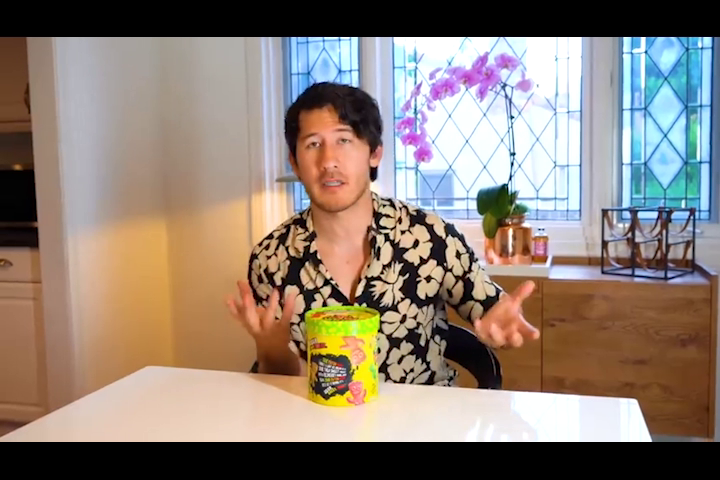

In [14]:
# root = "/content/drive/My Drive/Colab Notebooks/cs4243_smallest/" # assume cs4243_smallest is in Colab Notebooks folder
root = "./cs4243_smallest/" # on local machine
img_path = train_df['directory'][0]

img = Image.open(root + str(img_path)) #similar to cv2.imread()
img

# **Write your custom dataloader**

---

In [15]:
class CS4243_dataset(Dataset): 
    
    def __init__(self, root_path , dataframe, transform=None):
        
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['directory'] #image names
        self.labels = self.df['label']
                

    def __getitem__(self, index):
        
        img_path = self.image_paths[index] 
        image = Image.open(self.root_path + str(img_path))
        
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target]
       
    def __len__(self):
        return len(self.df)

In [16]:
batch_size = 256
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transformations = transforms.Compose([
                transforms.Resize(size=(224,224),interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.ToTensor(), #3*H*W, [0, 1]
                normalize]) # normalize with mean/std

In [17]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Loading and normalizing the data.
# Define transformations for the training and test sets
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# CIFAR10 dataset consists of 50K training images. We define the batch size of 10 to load 5,000 batches of images.
batch_size = 50
number_of_labels = 10
# number_of_labels = 3


### -------- Replace this portion with actual dataset and loader --------- ###

# Create an instance for training. 
# When we run this code for the first time, the CIFAR10 train dataset will be downloaded locally. 
train_set = CS4243_dataset(root, train_df, transform = transformations)

# Create a loader for the training set which will read the data within batch size and put into memory.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

# Create an instance for testing, note that train is set to False.
# When we run this code for the first time, the CIFAR10 test dataset will be downloaded locally. 
test_set = CS4243_dataset(root, test_df, transform=transformations)

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

### -------- Replace this portion with actual dataset and loader --------- ###

print("The number of batches per epoch is: ", len(train_loader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Should be something like this
# classes = ('carrying', 'normal', 'threat')

The number of images in a training set is:  750
The number of images in a test set is:  100
The number of batches per epoch is:  15


In [9]:
# Split dataset into test and train

# dataset_size = len(train_dataset)
# train_size = int(0.8 * dataset_size)
# test_size = dataset_size - train_size

# **Write network and training loop**

---


In [10]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, number_of_labels)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("[testAccuracy] The model will be running on", device, "device")
model.to(device)

[testAccuracy] The model will be running on cuda:0 device


Network(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2400, out_features=10, bias=True)
)

In [11]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [12]:
# Function to save the model
def saveModel():
    path = "./WeaponDetection.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    best_accuracy = 0.0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [13]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))
    # images, labels = images.to(device), labels.to(device)

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [14]:
# Function to test what classes performed well
def testClasses():
    # Need to set the device again after model is re-instantiated
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("[testClasses] The model will be running on", device, "device")
    model.to(device)

    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))

    with torch.no_grad():
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

[1,  1000] loss: 1.309
For epoch 1 the test accuracy over the whole test set is 59 %
[2,  1000] loss: 0.995
For epoch 2 the test accuracy over the whole test set is 66 %
[3,  1000] loss: 0.867
For epoch 3 the test accuracy over the whole test set is 68 %
Finished Training


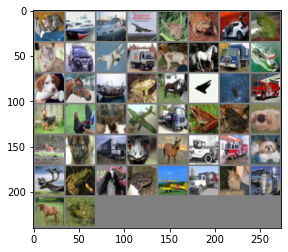

Real labels:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog
Predicted:    cat  ship  ship plane  frog   cat   car  frog   cat   car plane truck   cat horse truck  ship   dog   cat  ship  frog horse plane plane truck  deer  bird  deer plane   car  bird  frog   dog  bird   cat truck   cat horse truck truck   dog plane  frog   dog  frog plane truck   cat truck horse  bird
[testClasses] The model will be running on cuda:0 device
Accuracy of plane : 81 %
Accuracy of   car : 81 %
Accuracy of  bird : 40 %
Accuracy of   cat : 56 %
Accuracy of  deer : 52 %
Accuracy of   dog : 44 %
Accuracy of  frog : 61 %
Accuracy of horse : 78 %
Accuracy of  ship : 73 %
Accuracy of truck : 69 %


In [15]:
if __name__ == "__main__":
    
    # Let's build our model
    train(3)
    print('Finished Training')

    # Test which classes performed well
    testAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "WeaponDetection.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch()

    # Test which class performed the best
    testClasses()